In [2]:
import pandas as pd
import numpy as np                                             # dense matrices
import json
from scipy.sparse import csr_matrix                            # sparse matrices
from sklearn.metrics.pairwise import pairwise_distances        # pairwise distances
from copy import copy                                          # deep copies
import matplotlib.pyplot as plt                                # plotting
%matplotlib inline

'''compute norm of a sparse vector
   Thanks to: Jaiyam Sharma'''
def norm(x):
    sum_sq=x.dot(x.T)
    norm=np.sqrt(sum_sq)
    return(norm)

In [3]:
#Load in the dataset
wiki = pd.read_csv('people_wiki.csv')
wiki.head(3)
wiki.shape

(59071, 3)

In [4]:
#Extract TF-IDF vectors
def load_sparse_csr(filename):
    loader = np.load(filename)
    data = loader['data']
    indices = loader['indices']
    indptr = loader['indptr']
    shape = loader['shape']
    
    return csr_matrix( (data, indices, indptr), shape)

corpus = load_sparse_csr('people_wiki_tf_idf.npz')

In [5]:
#Load json file map_index_to_word
with open('people_wiki_map_index_to_word.json') as file:    
    map_index_to_word = json.load(file)

In [6]:
#Train an LSH model
#Generate a collection of random vectors from std Gaussian dist
def generate_random_vectors(num_vector, dim):
    return np.random.randn(dim, num_vector)
#Generate 3 random vectors of dimension 5, arranged into a single 5 x 3 matrix.
#np.random.seed(0) # set seed=0 for consistent results
#print(generate_random_vectors(num_vector=3, dim=5))

np.random.seed(0)
random_vectors = generate_random_vectors(num_vector=16, dim=547979)
powers_of_two = (1 << np.arange(15, -1, -1))

'''
Generate random vectors of the same dimensionality as our vocubulary size (547979). 
Each vector can be used to compute one bit in the bin encoding

#Generate 16 random vectors of dimension 547979
np.random.seed(0)
random_vectors = generate_random_vectors(num_vector=16, dim=547979)
print(random_vectors.shape)

#Partition data points into bins
doc = corpus[0, :] 
#vector of tf-idf values for document 0
#The first bit is given by the sign of the dot product 
#between the first random vector and the document's TF-IDF vector
print(doc.dot(random_vectors[:, 0]) >= 0 )
#True if positive sign; False if negative sign

print(doc.dot(random_vectors[:, 1]) >= 0)
print(doc.dot(random_vectors) >= 0) 
#return an array of 16 True/False bits
print(np.array(doc.dot(random_vectors) >= 0, dtype=int))
#display index bits in 0/1's
print(corpus[0:2].dot(random_vectors) >= 0) 
#compute bit indices of first two documents
print(corpus.dot(random_vectors) >= 0) 
#compute bit indices of ALL documents

doc = corpus[0, :]  #first document
index_bits = (doc.dot(random_vectors) >= 0)
powers_of_two = (1 << np.arange(15, -1, -1))
print(index_bits)
print(powers_of_two)           
#[32768, 16384, 8192, 4096, 2048, 1024, 512, 256, 128, 64, 32, 16, 8, 4, 2, 1]
print(index_bits.dot(powers_of_two))
index_bits = corpus.dot(random_vectors) >= 0
print(index_bits.dot(powers_of_two))
'''
def train_lsh(data, num_vector=16, seed=None):
    
    dim = data.shape[1]
    if seed is not None:
        np.random.seed(seed)
    random_vectors = generate_random_vectors(num_vector, dim)
  
    powers_of_two = 1 << np.arange(num_vector-1, -1, -1)
  
    table = {}
    
    #Partition data points into bins
    bin_index_bits = (data.dot(random_vectors) >= 0)
  
    #Encode bin index bits into integers
    bin_indices = bin_index_bits.dot(powers_of_two)
    
    #Update `table` so that `table[i]` is the list of document ids with bin index equal to i.
    for data_index, bin_index in enumerate(bin_indices):
        if bin_index not in table:
            #If no list yet exists for this bin, assign the bin an empty list.
            table[bin_index] = []
        #Fetch the list of document ids associated with the bin and add the document id to the end.
        table[bin_index].append(data_index)

    model = {'data': data,
             'bin_index_bits': bin_index_bits,
             'bin_indices': bin_indices,
             'table': table,
             'random_vectors': random_vectors,
             'num_vector': num_vector}
    
    return model

In [7]:
#Check point
model = train_lsh(corpus, num_vector=16, seed=143)
table = model['table']
if   0 in table and table[0]   == [39583] and \
   143 in table and table[143] == [19693, 28277, 29776, 30399]:
    print('Passed!')
else:
    print('Check your code.')

Passed!


In [19]:
#Inspect bins
print(wiki[wiki['name'] == 'Barack Obama'])
#the doc id of Obama = 35817
index_bin_Obama = corpus[35817,:].dot(random_vectors) >= 0
#integer index of the bin
print(index_bin_Obama.dot(powers_of_two))
print(index_bin_Obama % 2)
#bit index of the bin
print(np.array(model['bin_index_bits'][35817], dtype=int))

print(wiki[wiki['name'] == 'Joe Biden']) 
#the doc id Biden = 24478
index_bin_Biden = corpus[24478,:].dot(random_vectors) >= 0
#the integer index of bin for Biden
print(index_bin_Biden.dot(powers_of_two))
print(index_bin_Biden % 2)

print(np.array(model['bin_index_bits'][35817] == \
               model['bin_index_bits'][24478], dtype=int))
print(sum(model['bin_index_bits'][35817] == \
          model['bin_index_bits'][24478]))
#Examine the bit representations of the bins containing Barack Obama and Joe Biden. 
#In 14 places they agree

#Compare the result with a former British diplomat, 
#whose bin representation agrees with Obama's in only 8 out of 16 places
print(wiki[wiki['name']=='Wynn Normington Hugh-Jones'])
print(np.array(model['bin_index_bits'][22745], dtype=int)) # list of 0/1's
print(model['bin_index_bits'][35817] == model['bin_index_bits'][22745])

print(model['table'][model['bin_indices'][35817]])
#the documents in the same bin as Barack Obama
doc_ids = list(model['table'][model['bin_indices'][35817]])
doc_ids.remove(35817) 
#display documents other than Obama
docs = wiki.iloc[doc_ids] 
#filter by id column
#docs
#docsIt turns out that Joe Biden is much closer to Barack Obama
#than any of the four documents, even though Biden's bin representation
#differs from Obama's by 2 bits.

                                              URI          name  \
35817  <http://dbpedia.org/resource/Barack_Obama>  Barack Obama   

                                                    text  
35817  barack hussein obama ii brk husen bm born augu...  
[29090]
[[0 1 1 1 0 0 0 1 1 0 1 0 0 0 1 0]]
[1 1 0 0 0 1 0 0 0 0 0 1 0 0 1 0]
                                           URI       name  \
24478  <http://dbpedia.org/resource/Joe_Biden>  Joe Biden   

                                                    text  
24478  joseph robinette joe biden jr dosf rbnt badn b...  
[11619]
[[0 0 1 0 1 1 0 1 0 1 1 0 0 0 1 1]]
[1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1]
14
                                                     URI  \
22745  <http://dbpedia.org/resource/Wynn_Normington_H...   

                             name  \
22745  Wynn Normington Hugh-Jones   

                                                    text  
22745  sir wynn normington hughjones kb sometimes kno...  
[0 0 0 1 0 0 1 0 0 0 1 1 0 1 0 0]

,URI,name,text
21426,<http://dbpedia.org/resource/Mark_Boulware>,Mark Boulware,mark boulware born 1948 is an american diploma...
39426,<http://dbpedia.org/resource/John_Wells_(polit...,John Wells (politician),sir john julius wells born 30 march 1925 is a ...
50261,<http://dbpedia.org/resource/Francis_Longstaff>,Francis Longstaff,francis a longstaff born august 3 1956 is an a...
53937,<http://dbpedia.org/resource/Madurai_T._Sriniv...,Madurai T. Srinivasan,maduraitsrinivasan is a wellknown figure in th...


In [28]:
def cosine_distance(x, y):
    xy = x.dot(y.T)
    dist = xy/(norm(x)*norm(y))
    return 1-dist[0,0]

obama_tf_idf = corpus[35817,:]
biden_tf_idf = corpus[24478,:]

print('================= Cosine distance from Barack Obama')
print('Barack Obama - {0:24s}: {1:f}'.format(
      'Joe Biden', cosine_distance(obama_tf_idf, biden_tf_idf)))

for doc_id in doc_ids:
    doc_tf_idf = corpus[doc_id,:]
    print('Barack Obama - {0:24s}: {1:f}'.format(
          wiki.iloc[doc_id]['name'], cosine_distance(obama_tf_idf, doc_tf_idf)))
'''
Similar data points will in general tend to fall into nearby bins, 
but that's all we can say about LSH. In a high-dimensional space such as text features, 
we often get unlucky with our selection of only a few random vectors such that 
dissimilar data points go into the same bin while similar data points fall into different bins. 
Given a query document, we must consider all documents in the nearby bins 
and sort them according to their actual distances from the query.
'''    

================= Cosine distance from Barack Obama
Barack Obama - Joe Biden               : 0.703139
Barack Obama - Mark Boulware           : 0.950867
Barack Obama - John Wells (politician) : 0.975966
Barack Obama - Francis Longstaff       : 0.978256
Barack Obama - Madurai T. Srinivasan   : 0.993092


In [36]:
#Query the LSH model
'''
1. Let L be the bit representation of the bin that contains the query documents.
2. Consider all documents in bin L.
3. Consider documents in the bins whose bit representation differs from L by 1 bit.
4. Consider documents in the bins whose bit representation differs from L by 2 bits.
...
'''
from itertools import combinations
'''
1. Decide on the search radius r. This will determine the number of different bits between the two vectors.
2. For each subset (n_1, n_2, ..., n_r) of the list [0, 1, 2, ..., num_vector-1], do the following:
   * Flip the bits (n_1, n_2, ..., n_r) of the query bin to produce a new bit vector.
   * Fetch the list of documents belonging to the bin indexed by the new bit vector.
   * Add those documents to the candidate set.
'''
num_vector = 16
search_radius = 3

for diff in combinations(range(num_vector), search_radius):
    print(diff)

def search_nearby_bins(query_bin_bits, table, search_radius=2, initial_candidates=set()):
    """
    For a given query vector and trained LSH model, return all candidate neighbors for
    the query among all bins within the given search radius.
    
    Example usage
    -------------
    >>> model = train_lsh(corpus, num_vector=16, seed=143)
    >>> q = model['bin_index_bits'][0]  # vector for the first document
  
    >>> candidates = search_nearby_bins(q, model['table'])
    """
    num_vector = len(query_bin_bits)
    powers_of_two = 1 << np.arange(num_vector-1, -1, -1)
    
    # Allow the user to provide an initial set of candidates.
    candidate_set = copy(initial_candidates)
    
    for different_bits in combinations(range(num_vector), search_radius):       
        # Flip the bits (n_1,n_2,...,n_r) of the query bin to produce a new bit vector.
        ## Hint: you can iterate over a tuple like a list
        alternate_bits = copy(query_bin_bits)
        for i in different_bits:
            alternate_bits[i] = (alternate_bits[i] + 1) % 2
        
        # Convert the new bit vector to an integer index
        nearby_bin = alternate_bits.dot(powers_of_two)
        
        # Fetch the list of documents belonging to the bin indexed by the new bit vector.
        # Then add those documents to candidate_set
        # Make sure that the bin exists in the table!
        # Hint: update() method for sets lets you add an entire list to the set
        if nearby_bin in table:
            candidate_set |= set(table[nearby_bin])
            #Update candidate_set with the documents in this bin.
            
    return candidate_set    


(0, 1, 2)
(0, 1, 3)
(0, 1, 4)
(0, 1, 5)
(0, 1, 6)
(0, 1, 7)
(0, 1, 8)
(0, 1, 9)
(0, 1, 10)
(0, 1, 11)
(0, 1, 12)
(0, 1, 13)
(0, 1, 14)
(0, 1, 15)
(0, 2, 3)
(0, 2, 4)
(0, 2, 5)
(0, 2, 6)
(0, 2, 7)
(0, 2, 8)
(0, 2, 9)
(0, 2, 10)
(0, 2, 11)
(0, 2, 12)
(0, 2, 13)
(0, 2, 14)
(0, 2, 15)
(0, 3, 4)
(0, 3, 5)
(0, 3, 6)
(0, 3, 7)
(0, 3, 8)
(0, 3, 9)
(0, 3, 10)
(0, 3, 11)
(0, 3, 12)
(0, 3, 13)
(0, 3, 14)
(0, 3, 15)
(0, 4, 5)
(0, 4, 6)
(0, 4, 7)
(0, 4, 8)
(0, 4, 9)
(0, 4, 10)
(0, 4, 11)
(0, 4, 12)
(0, 4, 13)
(0, 4, 14)
(0, 4, 15)
(0, 5, 6)
(0, 5, 7)
(0, 5, 8)
(0, 5, 9)
(0, 5, 10)
(0, 5, 11)
(0, 5, 12)
(0, 5, 13)
(0, 5, 14)
(0, 5, 15)
(0, 6, 7)
(0, 6, 8)
(0, 6, 9)
(0, 6, 10)
(0, 6, 11)
(0, 6, 12)
(0, 6, 13)
(0, 6, 14)
(0, 6, 15)
(0, 7, 8)
(0, 7, 9)
(0, 7, 10)
(0, 7, 11)
(0, 7, 12)
(0, 7, 13)
(0, 7, 14)
(0, 7, 15)
(0, 8, 9)
(0, 8, 10)
(0, 8, 11)
(0, 8, 12)
(0, 8, 13)
(0, 8, 14)
(0, 8, 15)
(0, 9, 10)
(0, 9, 11)
(0, 9, 12)
(0, 9, 13)
(0, 9, 14)
(0, 9, 15)
(0, 10, 11)
(0, 10, 12)
(0, 10, 13)
(0, 10, 14

In [37]:
#Checkpoint
#search_radius=0 yields the list of documents belonging to the same bin as the query
obama_bin_index = model['bin_index_bits'][35817] # bin index of Barack Obama
candidate_set = search_nearby_bins(obama_bin_index, model['table'], 
                                   search_radius=0)
if candidate_set == set([35817, 21426, 53937, 39426, 50261]):
    print('Passed test')
else:
    print('Check your code')
print('List of documents in the same bin as Obama: \
35817, 21426, 53937, 39426, 50261')

#search_radius=1 adds more documents to the fore
candidate_set = search_nearby_bins(obama_bin_index, 
                                   model['table'], 
                                   search_radius=1, 
                                   initial_candidates=candidate_set)
if candidate_set == set([39426, 38155, 38412, 28444, 9757, 41631, 
                         39207, 59050, 47773, 53937, 21426, 34547,
                         23229, 55615, 39877, 27404, 33996, 21715, 
                         50261, 21975, 33243, 58723, 35817, 45676,
                         19699, 2804, 20347]):
    print('Passed test')
else:
    print('Check your code')

Passed test
List of documents in the same bin as Obama: 35817, 21426, 53937, 39426, 50261
Passed test


In [50]:
#collect all candidates and compute their true distance to the query
def query(vec, model, k, max_search_radius):
  
    data = model['data']
    table = model['table']
    random_vectors = model['random_vectors']
    num_vector = random_vectors.shape[1]
    
    
    # Compute bin index for the query vector, in bit representation.
    bin_index_bits = (vec.dot(random_vectors) >= 0).flatten()
    
    # Search nearby bins and collect candidates
    candidate_set = set()
    for search_radius in range(max_search_radius+1):
        candidate_set = search_nearby_bins(bin_index_bits, table, 
                                           search_radius, 
                                           initial_candidates=candidate_set)
    
    # Sort candidates by their true distances from the query
    nearest_neighbors = pd.DataFrame(index=candidate_set)
    candidates = data[np.array(list(candidate_set)),:]
    nearest_neighbors['distance'] = pairwise_distances(candidates, vec, 
                                                       metric='cosine').flatten()
    
    return nearest_neighbors.sort_values(by='distance', ascending=True)[:k], len(candidate_set)

In [52]:
print(query(corpus[35817,:], model, k=10, max_search_radius=3))
#try it out with Obama

result, num_candidates_considered = query(corpus[35817,:], 
                                          model, k=10, 
                                          max_search_radius=3)
print(result.join(wiki).sort_values(by='distance', 
                                    ascending=True)[['distance', 'name']])
#join this table with the Wikipedia table

(       distance
35817  0.000000
24478  0.703139
56008  0.856848
37199  0.874669
40353  0.890034
9267   0.898377
55909  0.899340
9165   0.900921
57958  0.903003
49872  0.909533, 727)
       distance                     name
35817  0.000000             Barack Obama
24478  0.703139                Joe Biden
56008  0.856848            Nathan Cullen
37199  0.874669  Barry Sullivan (lawyer)
40353  0.890034            Neil MacBride
9267   0.898377      Vikramaditya Khanna
55909  0.899340              Herman Cain
9165   0.900921     Raymond F. Clevenger
57958  0.903003        Michael J. Malbin
49872  0.909533            Lowell Barron


In [54]:
#Experiment with LSH implementation
#Effect of nearby bin search
#run LSH multiple times, 
#each with different radii for nearby bin search
''' 3 variables affected by search radius
Number of candidate documents considered
Query time
Distance of approximate neighbors from the query
'''
import time
num_candidates_history = []
query_time_history = []
max_distance_from_query_history = []
min_distance_from_query_history = []
average_distance_from_query_history = []

for max_search_radius in range(17):
    start=time.time()
    # Perform LSH query using Barack Obama, with max_search_radius
    result, num_candidates = query(corpus[35817,:], model, k=10,
                                   max_search_radius=max_search_radius)
    end=time.time()
    query_time = end-start  # Measure time
    
    print('Radius:', max_search_radius)
    # Display 10 nearest neighbors, along with document ID and name
    print(result.join(wiki).sort_values(by='distance', ascending=True))
    
    # Collect statistics on 10 nearest neighbors
    average_distance_from_query = result['distance'][1:].mean()
    max_distance_from_query = result['distance'][1:].max()
    min_distance_from_query = result['distance'][1:].min()
    
    num_candidates_history.append(num_candidates)
    query_time_history.append(query_time)
    average_distance_from_query_history.append(average_distance_from_query)
    max_distance_from_query_history.append(max_distance_from_query)
    min_distance_from_query_history.append(min_distance_from_query)

Radius: 0
       distance                                                URI  \
35817  0.000000         <http://dbpedia.org/resource/Barack_Obama>   
21426  0.950867        <http://dbpedia.org/resource/Mark_Boulware>   
39426  0.975966  <http://dbpedia.org/resource/John_Wells_(polit...   
50261  0.978256    <http://dbpedia.org/resource/Francis_Longstaff>   
53937  0.993092  <http://dbpedia.org/resource/Madurai_T._Sriniv...   

                          name  \
35817             Barack Obama   
21426            Mark Boulware   
39426  John Wells (politician)   
50261        Francis Longstaff   
53937    Madurai T. Srinivasan   

                                                    text  
35817  barack hussein obama ii brk husen bm born augu...  
21426  mark boulware born 1948 is an american diploma...  
39426  sir john julius wells born 30 march 1925 is a ...  
50261  francis a longstaff born august 3 1956 is an a...  
53937  maduraitsrinivasan is a wellknown figure in th...  
Radius: 1


Radius: 6
       distance                                                URI  \
35817  0.000000         <http://dbpedia.org/resource/Barack_Obama>   
24478  0.703139            <http://dbpedia.org/resource/Joe_Biden>   
38714  0.770561  <http://dbpedia.org/resource/Eric_Stern_(polit...   
44681  0.790926  <http://dbpedia.org/resource/Jesse_Lee_(politi...   
46811  0.800197        <http://dbpedia.org/resource/Jeff_Sessions>   
48693  0.809192          <http://dbpedia.org/resource/Artur_Davis>   
23737  0.810165    <http://dbpedia.org/resource/John_D._McCormick>   
4032   0.814555  <http://dbpedia.org/resource/Kenneth_D._Thompson>   
28447  0.823229       <http://dbpedia.org/resource/George_W._Bush>   
14754  0.826854          <http://dbpedia.org/resource/Mitt_Romney>   

                          name  \
35817             Barack Obama   
24478                Joe Biden   
38714  Eric Stern (politician)   
44681   Jesse Lee (politician)   
46811            Jeff Sessions   
48693          

Radius: 11
       distance                                                URI  \
35817  0.000000         <http://dbpedia.org/resource/Barack_Obama>   
24478  0.703139            <http://dbpedia.org/resource/Joe_Biden>   
38376  0.742982       <http://dbpedia.org/resource/Samantha_Power>   
57108  0.758358  <http://dbpedia.org/resource/Hillary_Rodham_Cl...   
38714  0.770561  <http://dbpedia.org/resource/Eric_Stern_(polit...   
46140  0.784678         <http://dbpedia.org/resource/Robert_Gibbs>   
44681  0.790926  <http://dbpedia.org/resource/Jesse_Lee_(politi...   
18827  0.798323         <http://dbpedia.org/resource/Henry_Waxman>   
2412   0.799466      <http://dbpedia.org/resource/Joe_the_Plumber>   
46811  0.800197        <http://dbpedia.org/resource/Jeff_Sessions>   

                          name  \
35817             Barack Obama   
24478                Joe Biden   
38376           Samantha Power   
57108   Hillary Rodham Clinton   
38714  Eric Stern (politician)   
46140         

Radius: 16
       distance                                                URI  \
35817  0.000000         <http://dbpedia.org/resource/Barack_Obama>   
24478  0.703139            <http://dbpedia.org/resource/Joe_Biden>   
38376  0.742982       <http://dbpedia.org/resource/Samantha_Power>   
57108  0.758358  <http://dbpedia.org/resource/Hillary_Rodham_Cl...   
38714  0.770561  <http://dbpedia.org/resource/Eric_Stern_(polit...   
46140  0.784678         <http://dbpedia.org/resource/Robert_Gibbs>   
6796   0.788039          <http://dbpedia.org/resource/Eric_Holder>   
44681  0.790926  <http://dbpedia.org/resource/Jesse_Lee_(politi...   
18827  0.798323         <http://dbpedia.org/resource/Henry_Waxman>   
2412   0.799466      <http://dbpedia.org/resource/Joe_the_Plumber>   

                          name  \
35817             Barack Obama   
24478                Joe Biden   
38376           Samantha Power   
57108   Hillary Rodham Clinton   
38714  Eric Stern (politician)   
46140         

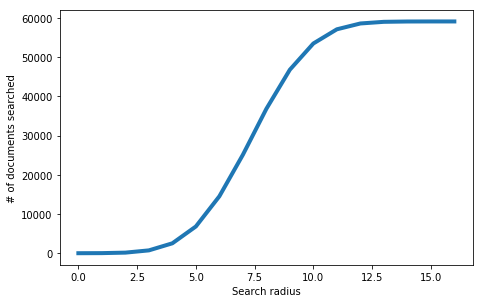

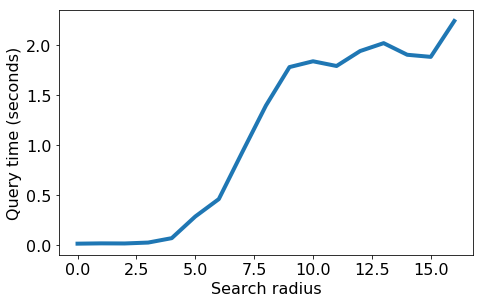

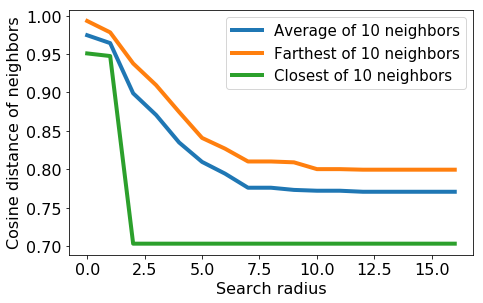

In [55]:
#Notice that the top 10 query results become more relevant as the search radius grows
plt.figure(figsize=(7,4.5))
plt.plot(num_candidates_history, linewidth=4)
plt.xlabel('Search radius')
plt.ylabel('# of documents searched')
plt.rcParams.update({'font.size':16})
plt.tight_layout()

plt.figure(figsize=(7,4.5))
plt.plot(query_time_history, linewidth=4)
plt.xlabel('Search radius')
plt.ylabel('Query time (seconds)')
plt.rcParams.update({'font.size':16})
plt.tight_layout()

plt.figure(figsize=(7,4.5))
plt.plot(average_distance_from_query_history, linewidth=4, label='Average of 10 neighbors')
plt.plot(max_distance_from_query_history, linewidth=4, label='Farthest of 10 neighbors')
plt.plot(min_distance_from_query_history, linewidth=4, label='Closest of 10 neighbors')
plt.xlabel('Search radius')
plt.ylabel('Cosine distance of neighbors')
plt.legend(loc='best', prop={'size':15})
plt.rcParams.update({'font.size':16})
plt.tight_layout()

'''
1. As we increase the search radius, we find more neighbors that are a smaller distance away.
2. With increased search radius comes a greater number documents that have to be searched. 
Query time is higher as a consequence.
3. With sufficiently high search radius, 
the results of LSH begin to resemble the results of brute-force search
'''

'''
Suppose our goal was to produce 10 approximate nearest neighbors 
whose average distance from the query document is within 0.01 of the average 
for the true 10 nearest neighbors. '''
#For Barack Obama, the true 10 nearest neighbors are on average about 0.77.
for i, v in enumerate(average_distance_from_query_history):
    if average_distance_from_query_history[i] <= 0.78:
        print(i, v)
        break

In [61]:
#Quality metrics for neighbors
#run LSH multiple times with different search radii
#measured by 2 metrics:
'''
Precision@10: How many of the 10 neighbors given by LSH are 
              among the true 25 nearest neighbors?
Average cosine distance of the neighbors from the query
'''

def brute_force_query(vec, data, k):
    num_data_points = data.shape[0]
    
    # Compute distances for ALL data points in training set
    nearest_neighbors = pd.DataFrame(index=range(num_data_points))
    nearest_neighbors['distance'] = pairwise_distances(data, 
                                                       vec, 
                                                       metric='cosine').flatten()
    
    return nearest_neighbors.sort_values(by='distance', 
                                         ascending=True)[:k]

#run LSH with multiple search radii
#compute the quality metrics for each run
max_radius = 17
precision = {i:[] for i in range(max_radius)}
average_distance  = {i:[] for i in range(max_radius)}
query_time  = {i:[] for i in range(max_radius)}

np.random.seed(0)
num_queries = 10
for i, ix in enumerate(np.random.choice(corpus.shape[0], 
                                        num_queries, 
                                        replace=False)):
    print('%s / %s' % (i, num_queries))
    ground_truth = set(brute_force_query(corpus[ix,:], 
                                         corpus, k=25).index.values)
    # Get the set of 25 true nearest neighbors
    
    for r in range(1,max_radius):
        start = time.time()
        result, num_candidates = query(corpus[ix,:], model, 
                                       k=10, max_search_radius=r)
        end = time.time()

        query_time[r].append(end-start)
        # precision = (# of neighbors both in result and ground_truth)/10.0
        precision[r].append(len(set(result.index.values) & 
                                ground_truth)/10.0)
        average_distance[r].append(result['distance'][1:].mean())

0 / 10
1 / 10
2 / 10
3 / 10
4 / 10
5 / 10
6 / 10
7 / 10
8 / 10
9 / 10


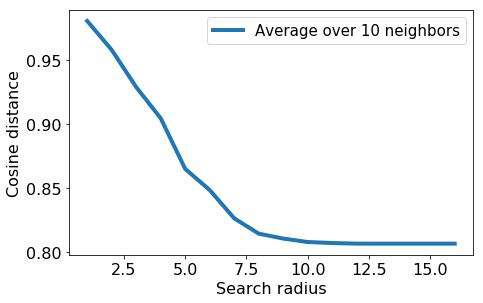

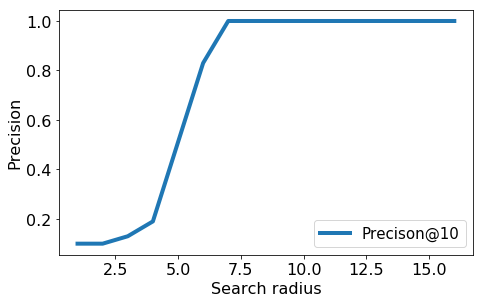

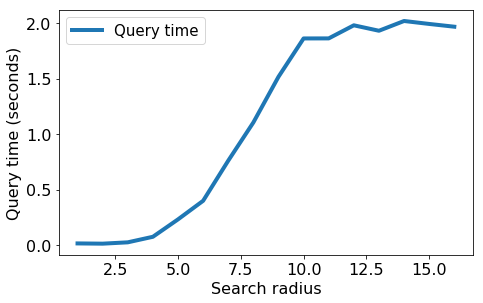

In [63]:

plt.figure(figsize=(7,4.5))
plt.plot(range(1,17), [np.mean(average_distance[i]) for i in range(1,17)], 
         linewidth=4, label='Average over 10 neighbors')
plt.xlabel('Search radius')
plt.ylabel('Cosine distance')
plt.legend(loc='best', prop={'size':15})
plt.rcParams.update({'font.size':16})
plt.tight_layout()

plt.figure(figsize=(7,4.5))
plt.plot(range(1,17), [np.mean(precision[i]) for i in range(1,17)], 
         linewidth=4, label='Precison@10')
plt.xlabel('Search radius')
plt.ylabel('Precision')
plt.legend(loc='best', prop={'size':15})
plt.rcParams.update({'font.size':16})
plt.tight_layout()

plt.figure(figsize=(7,4.5))
plt.plot(range(1,17), [np.mean(query_time[i]) for i in range(1,17)], 
         linewidth=4, label='Query time')
plt.xlabel('Search radius')
plt.ylabel('Query time (seconds)')
plt.legend(loc='best', prop={'size':15})
plt.rcParams.update({'font.size':16})
plt.tight_layout()

'''
The observations for Barack Obama generalize to the entire dataset
'''

In [65]:
#Effect of number of random vectors
#run LSH with different number of random vectors, 
#ranging from 5 to 20 with radius=3
precision = {i:[] for i in range(5,20)}
average_distance  = {i:[] for i in range(5,20)}
query_time = {i:[] for i in range(5,20)}
num_candidates_history = {i:[] for i in range(5,20)}
ground_truth = {}

np.random.seed(0)
num_queries = 10
docs = np.random.choice(corpus.shape[0], num_queries, replace=False)

for i, ix in enumerate(docs):
    ground_truth[ix] = set(brute_force_query(corpus[ix,:], 
                                             corpus, k=25).index.values)
    # Get the set of 25 true nearest neighbors

for num_vector in range(5,20):
    print('num_vector = %s' % (num_vector))
    model = train_lsh(corpus, num_vector, seed=143)
    
    for i, ix in enumerate(docs):
        start = time.time()
        result, num_candidates = query(corpus[ix,:], model, 
                                       k=10, max_search_radius=3)
        end = time.time()
        
        query_time[num_vector].append(end-start)
        precision[num_vector].append(len(set(result.index.values) & 
                                         ground_truth[ix])/10.0)
        average_distance[num_vector].append(result['distance'][1:].mean())
        num_candidates_history[num_vector].append(num_candidates)

num_vector = 5
num_vector = 6
num_vector = 7
num_vector = 8
num_vector = 9
num_vector = 10
num_vector = 11
num_vector = 12
num_vector = 13
num_vector = 14
num_vector = 15
num_vector = 16
num_vector = 17
num_vector = 18
num_vector = 19


'\nThere is a similar trade-off between quality and performance: \nas the number of random vectors increases, \nthe query time goes down as each bin contains fewer documents on average, \nbut on average the neighbors are likewise placed farther from the query. \nOn the other hand, when using a small enough number of random vectors, \nLSH becomes very similar brute-force search: \nMany documents appear in a single bin, \nso searching the query bin alone covers a lot of the corpus; \nthen, including neighboring bins might result in searching all documents, \njust as in the brute-force approach.\n'

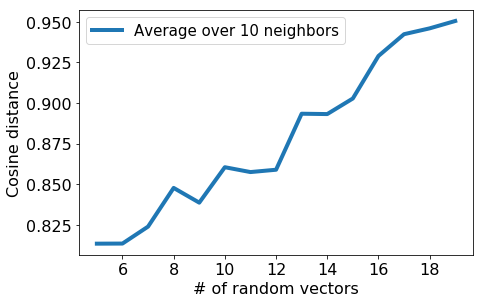

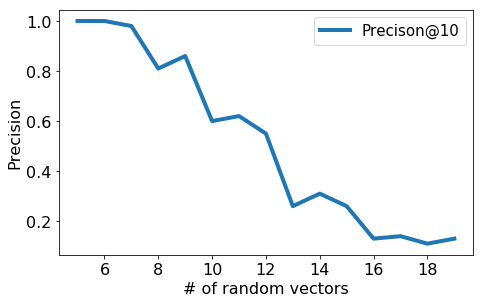

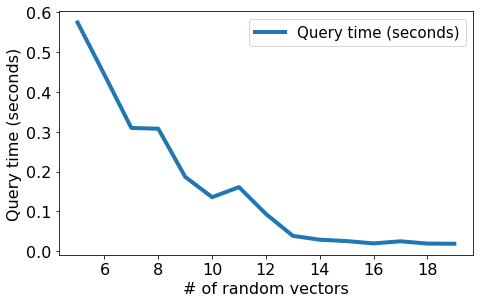

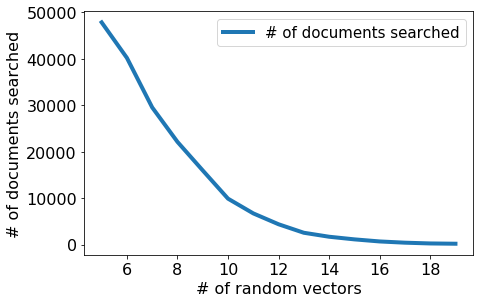

In [67]:
#Plot the metrics as a function of the number of random rectors
plt.figure(figsize=(7,4.5))
plt.plot(range(5,20), [np.mean(average_distance[i]) for i in range(5,20)], 
         linewidth=4, label='Average over 10 neighbors')
plt.xlabel('# of random vectors')
plt.ylabel('Cosine distance')
plt.legend(loc='best', prop={'size':15})
plt.rcParams.update({'font.size':16})
plt.tight_layout()

plt.figure(figsize=(7,4.5))
plt.plot(range(5,20), [np.mean(precision[i]) for i in range(5,20)], 
         linewidth=4, label='Precison@10')
plt.xlabel('# of random vectors')
plt.ylabel('Precision')
plt.legend(loc='best', prop={'size':15})
plt.rcParams.update({'font.size':16})
plt.tight_layout()

plt.figure(figsize=(7,4.5))
plt.plot(range(5,20), [np.mean(query_time[i]) for i in range(5,20)], 
         linewidth=4, label='Query time (seconds)')
plt.xlabel('# of random vectors')
plt.ylabel('Query time (seconds)')
plt.legend(loc='best', prop={'size':15})
plt.rcParams.update({'font.size':16})
plt.tight_layout()

plt.figure(figsize=(7,4.5))
plt.plot(range(5,20), [np.mean(num_candidates_history[i]) for i in range(5,20)], 
         linewidth=4, label='# of documents searched')
plt.xlabel('# of random vectors')
plt.ylabel('# of documents searched')
plt.legend(loc='best', prop={'size':15})
plt.rcParams.update({'font.size':16})
plt.tight_layout()

'''
There is a similar trade-off between quality and performance: 
as the number of random vectors increases, 
the query time goes down as each bin contains fewer documents on average, 
but on average the neighbors are likewise placed farther from the query. 
On the other hand, when using a small enough number of random vectors, 
LSH becomes very similar brute-force search: 
Many documents appear in a single bin, 
so searching the query bin alone covers a lot of the corpus; 
then, including neighboring bins might result in searching all documents, 
just as in the brute-force approach.
'''